Este script avalia e compara o desempenho de três modelos de recuperação de informação:
- Vetorial (TF-IDF)
- BM25
- Solr

As métricas utilizadas são:
- Gráfico de Precisão x Recall Interpolado (11 pontos)
- F1-Score médio


Imports

In [30]:
import json
import logging
import numpy as np
import matplotlib.pyplot as plt

Configuração

In [31]:
# --- Configuração do Logger ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Constantes ---
ID_DA_CONSULTA_ALVO = "182"

# Níveis de recall padrão para a interpolação
RECALL_LEVELS = np.linspace(0.0, 1.0, 11)

# Arquivos de entrada
ARQUIVOS_RESULTADOS = {
    'Vetorial (TF-IDF)': 'resultados_vetorial.json',
    'BM25': 'resultados_bm25.json',
    'Solr': 'resultados_solr.json'
}
ARQUIVO_GABARITO = 'map_consultas_relevancias.json'

Função de Cálculo de Métricas

In [32]:
def calcular_metricas(retrieved_ids, relevant_ids_set):
    """
    Calcula a precisão interpolada em 11 pontos e o F1-Score para uma única consulta.
    """
    if not relevant_ids_set:
        return ([0.0] * 11, 0.0) # Retorna 0 se não há documentos relevantes

    retrieved_count = 0
    relevant_found_count = 0
    
    precision_values = []
    recall_values = []

    for doc_id in retrieved_ids:
        retrieved_count += 1
        if doc_id in relevant_ids_set:
            relevant_found_count += 1
            precision = relevant_found_count / retrieved_count
            recall = relevant_found_count / len(relevant_ids_set)
            precision_values.append(precision)
            recall_values.append(recall)

    # Calcula F1-Score para a lista completa de documentos recuperados
    precision_final = relevant_found_count / len(retrieved_ids) if retrieved_ids else 0.0
    recall_final = relevant_found_count / len(relevant_ids_set)
    f1_score = 0.0
    if (precision_final + recall_final) > 0:
        f1_score = 2 * (precision_final * recall_final) / (precision_final + recall_final)

    # Interpolação da Precisão
    interpolated_precision = []
    for r_level in RECALL_LEVELS:
        precisions_at_level = [p for r, p in zip(recall_values, precision_values) if r >= r_level]
        interpolated_precision.append(max(precisions_at_level) if precisions_at_level else 0.0)
        
    return (interpolated_precision, f1_score)

Carregamento dos Dados e Preparação

In [33]:
# Carregar o gabarito
try:
    with open(ARQUIVO_GABARITO, 'r', encoding='utf-8') as f:
        gabarito = json.load(f)
    logging.info(f"Arquivo de relevâncias '{ARQUIVO_GABARITO}' carregado com sucesso.")
except FileNotFoundError:
    logging.error(f"Arquivo de relevâncias '{ARQUIVO_GABARITO}' não encontrado. Abortando.")
    gabarito = None

# Dicionário para armazenar o desempenho de cada modelo
desempenho_modelos = {}

2025-07-22 06:33:04,203 - INFO - Arquivo de relevâncias 'map_consultas_relevancias.json' carregado com sucesso.


Processamento e Avaliação dos Modelos

In [34]:
# Processar cada modelo
if gabarito:
    for nome_modelo, nome_arquivo in ARQUIVOS_RESULTADOS.items():
        try:
            with open(nome_arquivo, 'r', encoding='utf-8') as f:
                # Os arquivos de resultado devem conter uma lista de IDs para a consulta alvo
                retrieved_docs = json.load(f)
                if not isinstance(retrieved_docs, list):
                     logging.error(f"O arquivo {nome_arquivo} não contém uma lista. Formato inesperado.")
                     continue
            logging.info(f"Resultados do modelo '{nome_modelo}' carregados de '{nome_arquivo}'.")
        except FileNotFoundError:
            logging.warning(f"Arquivo de resultados '{nome_arquivo}' não encontrado. Pulando modelo '{nome_modelo}'.")
            continue
        except json.JSONDecodeError:
            logging.error(f"Erro ao decodificar JSON do arquivo {nome_arquivo}. Pulando modelo.")
            continue

        # 3. Avaliar a consulta alvo
        if ID_DA_CONSULTA_ALVO in gabarito:
            relevant_docs = gabarito[ID_DA_CONSULTA_ALVO]
            relevant_docs_set = set(map(int, relevant_docs))
            
            p_interpolada, f1 = calcular_metricas(retrieved_docs, relevant_docs_set)
            
            # 4. Armazenar as métricas para o modelo (sem média)
            desempenho_modelos[nome_modelo] = {'precisao': p_interpolada, 'f1': f1}
            logging.info(f"Métricas para o modelo '{nome_modelo}' calculadas para a consulta {ID_DA_CONSULTA_ALVO}.")
        else:
            logging.warning(f"A consulta alvo '{ID_DA_CONSULTA_ALVO}' não foi encontrada no gabarito.")
            break # Para o loop se a consulta alvo não existe


2025-07-22 06:33:04,218 - INFO - Resultados do modelo 'Vetorial (TF-IDF)' carregados de 'resultados_vetorial.json'.
2025-07-22 06:33:04,219 - INFO - Métricas para o modelo 'Vetorial (TF-IDF)' calculadas para a consulta 182.
2025-07-22 06:33:04,222 - INFO - Resultados do modelo 'BM25' carregados de 'resultados_bm25.json'.
2025-07-22 06:33:04,222 - INFO - Métricas para o modelo 'BM25' calculadas para a consulta 182.
2025-07-22 06:33:04,224 - INFO - Resultados do modelo 'Solr' carregados de 'resultados_solr.json'.
2025-07-22 06:33:04,225 - INFO - Métricas para o modelo 'Solr' calculadas para a consulta 182.


Plotagem e Impressão dos Resultados

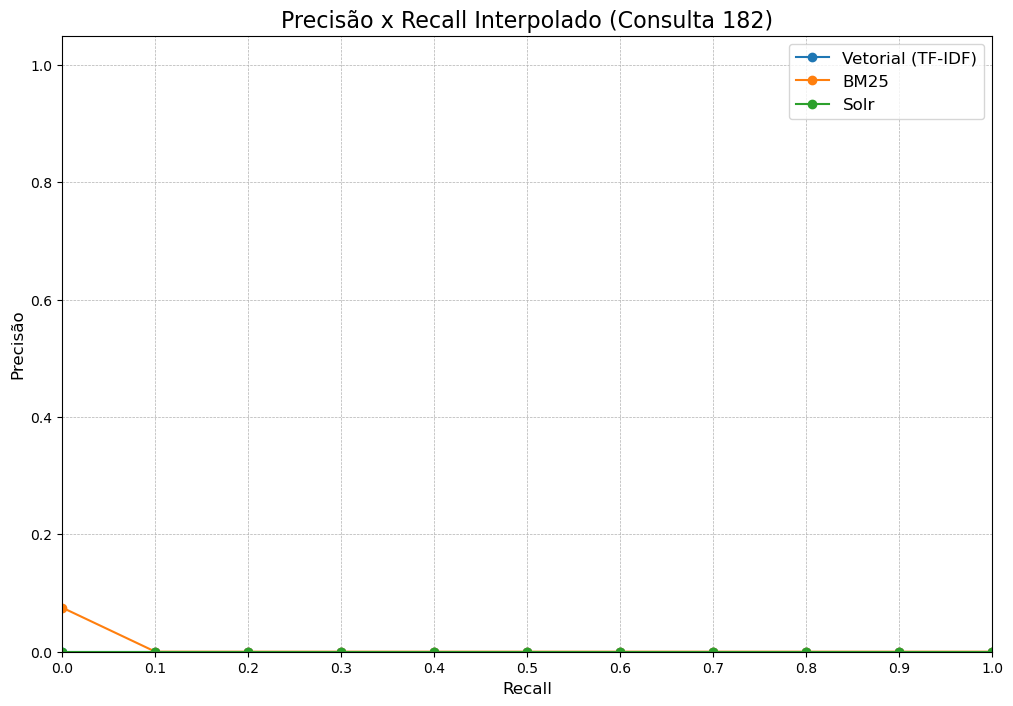


--- F1-Score por Modelo (Consulta 182) ---
Vetorial (TF-IDF)   : 0.0000
BM25                : 0.0112
Solr                : 0.0000


In [35]:
# Plotar o gráfico
if not desempenho_modelos:
    logging.error("Nenhum modelo foi avaliado. Verifique os arquivos de resultado e o ID da consulta.")
else:
    plt.figure(figsize=(12, 8))
    for nome_modelo, metricas in desempenho_modelos.items():
        plt.plot(RECALL_LEVELS, metricas['precisao'], marker='o', linestyle='-', label=nome_modelo)

    plt.title(f'Precisão x Recall Interpolado (Consulta {ID_DA_CONSULTA_ALVO})', fontsize=16)
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precisão', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.xticks(RECALL_LEVELS)
    plt.ylim(0, 1.05)
    plt.xlim(0, 1.0)
    plt.show()

    # 6. Imprimir F1-Scores
    print(f"\n--- F1-Score por Modelo (Consulta {ID_DA_CONSULTA_ALVO}) ---")
    for nome_modelo, metricas in desempenho_modelos.items():
        print(f"{nome_modelo:<20}: {metricas['f1']:.4f}")